<img src="https://brand.umich.edu/assets/brand/style-guide/logo-guidelines/U-M_Logo-Horizontal-Hex.png" alt="Drawing" style="width: 300px;" align="left"/><br>

## Week 3: Predictive Model
 
Predictive models are tools that, when developed and implemented well, help in accomplishing a task. By task, we mean more than merely making predictions; we mean using predictions to either allocate resources differently (i.e., prioritize) or recommend one course of action over another for a learner (i.e., personalize). Thus, prior to building any model, we need to answer an important question: Would I do something differently if two learners had different predicted scores? One evidence-based strategy that we want to deploy differently to different students is a brief check-in routine. This routine is comprised of setting up a meeting time with a student, identifying where they are struggling, and helping them in both building their confidence that they can overcome struggle and providing them with specific strategies for doing so.
 
If a learning analytics project has a need to prioritize or personalize, then the question becomes, can I predict the negative outcome that the new prioritization of resources or personalized strategy is intended to subvert? In this Notebook, we are going to develop a model to identify students who are at risk of failing the course. Given the number of students in the course, a model could potentially help in identifying which students to have a "check-in" conversation with. For this initial model, we will constrain the timeframe from which we will make our prediction to on or before **day 60** in the course. We are aligning our prediction window with the needs of a typical course instructor, which include a prioritized list of students to reach out to approximately 25% of the way into the course.

### Dictionary
- **student_info.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **gender** = character; M = "male", F = "female"
    - **highest_education** = character; “Some Graduate”, “Some Higher Education”, “High School + Advanced Placement”, “High School”, “No Formal Quals” (Categories ordered from highest documented education level attained to lowest documented education level attained)
    - **disability** = character; Y = "yes", N = "no"
    - **final_result** = character; "Fail", "Pass"


- **quizzes_tests.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **assignment_name** = character; name of graded assignment (Quiz 1-7, Test 1-6, Final Exam)
    - **due_date** = numeric; date assignment was due (indexed as count in days from start of course, i.e., day 0)
    - **weight** = numeric; weight multiplied by score when generating final grade (weight * score / 100)
    - **date_submitted** = numeric; date student submitted assigned (indexed as count in days from start of course, i.e., day 0, NaN means students did not submit assignment)
    - **score** = numeric; score student earned on assignment (0 means students did not submit assignment)


- **learning_resources.csv**
    - **id_student** = numeric; unique identifier for each student in the course
    - **activity_type** = character; overarching label for learning activity students can access (“course_homepage”, “course_page”, “forum”, ‘resource”, “wiki”)
    - **activity_id** = numeric; unique identifier for specific learning activity student accessed within overacting `activity_type`
    - **date** = numeric; date student accessed specific `acitivity_id`  (indexed as count in days from start of course, i.e., day 0)
    - **sum_click** = numeric; count of clicks for `activity_id` on date

In [1]:
import pandas as pd
import numpy as np

# Choose your classifier!
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Packages that will help
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [2]:
lr = pd.read_csv('assets/learning_resources.csv')
qt = pd.read_csv('assets/quizzes_tests.csv')
si = pd.read_csv('assets/student_info.csv')

## 1. Wrangle (10 points)

To build your model, you will wrangle all three of datasets. The kind of data wrangling we are looking for in this initial step will involve, first, sub-setting the dataset to not include information beyond day 60. Second, it will involve engineering features within a given dataset.

A lot of feature engineering will need to take place within the `learning_resources.csv` file as it provides a very granular representation of learners' online activity. For example, a reasonable set of features could include "total clicks by resource type." To generate these features will involve using `groupby` and rotating long-form data into wide-form. Your wrangling will be complete when you have joined all three sub-set and engineered files into one flat file.

### Grading

1.1. (2 points) Extract and recode `final_result`

1.2. (3 points) Create two or more features from `quizzes_tests.csv`, with at least one continuous variable

1.3. (3 points) Create two or more features from `learning_resources.csv`, with at least one continuous variable

1.4. (2 points) Join datasets into one flat file

**Note:** Make sure to not include any information from beyond day 60 in the course.

## Student information

Luckily, `student_info.csv`, does not require much wrangling. However, we will want to be mindful about including only actionable features in our model. For example, `gender`, `highest_education`, and `disability` are present in this dataset. These factors are important to understand and explore when users have the opportunity to reflect on an analysis; these kinds of factors, however, can lead to unfair prediction models. For example, it may be useful to know that students with "Some Higher Education" outperform, on average, students whose highest documented education is "High School." This kind of analysis could help administrators better think about the support services they provide to learners. 

When used in a predictive model, however, the average performance gap between these two groups could drive a prediction lower for a student whose highest documented education is "High School" even if she is performing well on quizzes and tests, which are the drivers of student success in the course. In this case, quizzes and tests are more actionable than prior education because both teacher and student can do something different based on these data. Thus for `student_info.csv`, we will only extract `id_student` and `final_result`. Lastly, we will recode `final_result` so that our resulting predictions capture a probability of failing the course.

**Note: You will lose all points for the entire "Wrangle" section if you include** `gender`, `highest_education`, **and/or** `disability`.

1.1. (2 points) Extract and recode `final_result`

In [3]:
## Your code with comments
# YOUR CODE HERE
si = si[["id_student", "final_result"]].replace({"Fail":0, "Pass":1}).set_index("id_student")
#raise NotImplementedError()

## Quizzes and tests

The `quizzes_tests.csv` file will require more wrangling as it needs to be both subset and rotated from long to wide. You should also apply the `weight` to `score` to get the most accurate representation for each quiz or test (weight * score / 100).

Possible features include the weighted quiz and test scores, whether or not quizzes and tests were simply turned in, and in addtion to these whether or not quizzes were late or on time.

Key to working with data from before day 60 are two columns, `due_date` and `date_submitted`. Proper subsetting involves starting with `due_date` as it is common for all students for each assignment. Thus, `due_date` gives us an equivalent baseline for all learners (i.e., if an assignment, regardless of when a student completed it, is due on day 65, we won’t include it as that is after day 60). But, since we are working with historical data, there could students in our dataset who turned in an assignment due on or before day 60, but did so **late**. Thus, if we only use `due_date`, we let this data beyond day 60 in, i.e., leakage. Thus, after subsetting by `due_date`, one should then subset by `date_submitted`.

1.2. (3 points) Create two or more features from `quizzes_tests.csv`, with at least one continuous variable

In [4]:
## Your code with comments
# YOUR CODE HERE
qt_clean = qt[qt["due_date"] <= 60].copy()
qt_clean.loc[qt_clean["date_submitted"] > 60, "score"] = 0 # set the score for items not yet submitted at day 60 to 0
qt_clean.loc[qt_clean["date_submitted"] > 60, "date_submitted"] = np.nan # if the assignment was not turned in by day 60, it is considered not turned in i.e. null

# ideas for features: weighted score on every assignment, whether or not turned it by day 60, whether or not late (i.e. submitted after due date, on or before day 60)

qt_clean["weighted_score"] = (qt_clean["weight"] * qt_clean["score"])/100
qt_clean["not_submitted"] = qt_clean["date_submitted"].isna().astype(int)
qt_clean["submitted_on_time"] = (qt_clean["date_submitted"] <= qt_clean["due_date"]).astype(int)

qt_scores = qt_clean.pivot(index="id_student", columns="assignment_name", values="weighted_score")
qt_scores.columns = [f"score_{name}" for name in qt_scores.columns]

qt_not_submitted = qt_clean.pivot(index="id_student", columns="assignment_name", values="not_submitted")
qt_not_submitted.columns = [f"not_submit_{name}" for name in qt_not_submitted.columns]

qt_late = qt_clean.pivot(index="id_student", columns="assignment_name", values="submitted_on_time")
qt_late.columns = [f"on_time_{name}" for name in qt_late.columns]

qt_features = pd.concat([qt_scores, qt_not_submitted, qt_late], axis=1)
#raise NotImplementedError()

## Learning resources

The `learning_resources.csv` provides a high degree of flexibility in how to engineer potential features. **Proper subsetting** of this file involves not including any resource beyond `date` <= 60.

1.3 (3 points) Create two or more features from `learning_resources.csv`, with at least one continuous variable

In [5]:
## Your code with comments
# YOUR CODE HERE
lr_clean = lr[lr["date"] <= 60].copy()
clicks_by_activity_type = lr_clean.groupby(["id_student", "activity_type"], as_index=False)["sum_click"].sum().pivot(index="id_student", columns="activity_type", values="sum_click")
clicks_by_activity_type.columns = [f"clicks_{name}" for name in clicks_by_activity_type.columns]

n_days_used_resources = lr_clean.groupby(["id_student"])[["date"]].nunique()
n_days_used_resources.columns = ["count_days_used_lr"]

lr_features = pd.concat([clicks_by_activity_type, n_days_used_resources], axis=1).fillna(0)
lr_features
#raise NotImplementedError()

,clicks_course_homepage,clicks_course_page,clicks_forum,clicks_resource,clicks_wiki,count_days_used_lr
id_student,,,,,,
41060,37.0,108.0,16.0,19.0,11.0,14
45664,144.0,141.0,107.0,115.0,29.0,19
52014,47.0,43.0,26.0,8.0,20.0,20
53488,173.0,98.0,332.0,65.0,39.0,36
60135,629.0,456.0,456.0,185.0,78.0,53
...,...,...,...,...,...,...
2678338,385.0,236.0,194.0,108.0,79.0,51
2683836,100.0,112.0,108.0,47.0,30.0,19
2689536,74.0,108.0,34.0,43.0,3.0,18


## Join files

1.4 (2 points) Join datasets into one flat file

In [6]:
## Your code with comments
# YOUR CODE HERE
df = pd.concat([si, qt_features, lr_features], axis=1).fillna(0) # fill na because some students never used the learning resources
student_index_map = df.index
df = df.reset_index(drop=True)
df
#raise NotImplementedError()

,final_result,score_Quiz 1,score_Quiz 2,score_Test 1,score_Test 2,not_submit_Quiz 1,not_submit_Quiz 2,not_submit_Test 1,not_submit_Test 2,on_time_Quiz 1,on_time_Quiz 2,on_time_Test 1,on_time_Test 2,clicks_course_homepage,clicks_course_page,clicks_forum,clicks_resource,clicks_wiki,count_days_used_lr
0,0,1.54,2.82,6.375,8.6,0,0,0,0,0,0,1,1,37.0,108.0,16.0,19.0,11.0,14.0
1,1,0.94,0.00,4.950,4.6,0,1,0,0,0,0,1,1,144.0,141.0,107.0,115.0,29.0,19.0
2,0,1.06,1.59,6.075,7.0,0,0,0,0,0,0,1,1,47.0,43.0,26.0,8.0,20.0,20.0
3,1,1.86,2.91,6.000,6.1,0,0,0,0,0,0,1,1,173.0,98.0,332.0,65.0,39.0,36.0
4,1,1.14,2.58,5.700,7.6,0,0,0,0,0,0,1,1,629.0,456.0,456.0,185.0,78.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,0,1.00,2.67,5.625,7.2,0,0,0,0,0,0,1,1,385.0,236.0,194.0,108.0,79.0,51.0
809,1,1.60,2.76,6.300,7.8,0,0,0,0,0,0,1,1,100.0,112.0,108.0,47.0,30.0,19.0
810,1,1.54,3.00,6.750,8.6,0,0,0,0,0,0,1,1,74.0,108.0,34.0,43.0,3.0,18.0
811,1,1.94,2.91,5.775,7.5,0,0,0,0,0,0,1,1,203.0,276.0,299.0,137.0,62.0,36.0


# 2. Modeling (30 points)

You should split the original data into an 80/20 split and train two different algorithms. Two algorithms are brought in at the top of the Notebook, `LogisticRegression` and `RandomForestClassifier`, but feel free to integrate others that interest you or that seem well suited to the task. To compare these two classifiers, you will use cross-validation on the training set (i.e., the 80% from the original), with the goal of identifying the classifier with the highest AUC. After identifying the best algorithm, you will fit it to your held out test-set and examine the model's calibration, i.e., the relationship between predicted probabilities and observed failure rates. Finally, you will visualize your predicted probabilities and identify a probability cut-off for checking-in with the highest risk students.

### Grading
2.1. (2 points) Split the original dataset into 80/20 train-test sets

2.2. (5 points) Pre-process continuous variables in a pipeline that avoids data leakage

2.3. (10 points) Develop and compare two different classifiers using cross-validated AUC

2.4. (2 points) Apply best performing classifier to test-set and report AUC

2.5. (5 points) Create calibration curve on test-set

2.6. (4 points) Visualize distribution of predicted probabilities using a box plot or histogram

2.7. (2 points) Identify predicted probability threshold to identify the top 20% highest risk students

2.1. (2 points) Split the original dataset into 80/20 train-test sets

In [7]:
## Your code with comments
# YOUR CODE HERE
train = df.sample(frac=0.8)
test = df[~df.index.isin(train.index)]
X_train = train.drop(columns = ["final_result"])
y_train = train["final_result"]
X_test = test.drop(columns = ["final_result"])
y_test = test["final_result"]
#raise NotImplementedError()

2.2. (5 points) Pre-process continuous variables in a pipeline that avoids data leakage

**Note:** https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [8]:
df.columns

Index(['final_result', 'score_Quiz 1', 'score_Quiz 2', 'score_Test 1',
       'score_Test 2', 'not_submit_Quiz 1', 'not_submit_Quiz 2',
       'not_submit_Test 1', 'not_submit_Test 2', 'on_time_Quiz 1',
       'on_time_Quiz 2', 'on_time_Test 1', 'on_time_Test 2',
       'clicks_course_homepage', 'clicks_course_page', 'clicks_forum',
       'clicks_resource', 'clicks_wiki', 'count_days_used_lr'],
      dtype='object')

In [9]:
## Your code with comments
# YOUR CODE HERE
# custom class to allow the column select because we do not have ColumnTransformer from sklearn
class StandardScaler_column_selector():
    def __init__(self, columns):
        self.scaler = StandardScaler()
        self.columns = columns
    
    def fit(self, x, y):
        x_scaled = x[self.columns]
        self.scaler.fit(x_scaled)
        return self
        
    def transform(self, x):
        x_cols = x[self.columns]
        x_part1 = pd.DataFrame(self.scaler.transform(x_cols), columns = x_cols.columns, index= x_cols.index)
        x_part2 = x[[col for col in x.columns if col not in self.columns]].copy()
        x_transformed = pd.concat([x_part1, x_part2], axis=1)[x.columns]
                               
        return x_transformed


continuous_columns = ['score_Quiz 1', 'score_Quiz 2', 'score_Test 1', 'score_Test 2']
scaler = StandardScaler_column_selector(continuous_columns)
# scaler.fit(X_train, y_train)

pipe = Pipeline([("scaler", scaler), ("model", LogisticRegression(max_iter=1000))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
#raise NotImplementedError()

0.8159509202453987

2.3. (10 points) Develop and compare two different classifiers using cross-validated AUC

**Classifier 1**

In [10]:
## Your code with comments
# YOUR CODE HERE
model1 = LogisticRegression(max_iter=5000)
clf1 = Pipeline([("scaler", scaler), ("model", model1)])

cv_auc1 = cross_val_score(clf1, X_train, y_train, scoring = "roc_auc")
cv_auc1.mean()
#raise NotImplementedError()

0.8136367603262034

**Classifier 2**

In [11]:
## Your code with comments
# YOUR CODE HERE
clf2 = Pipeline([("scaler", scaler), ("model", RandomForestClassifier())])

cv_auc2 = cross_val_score(clf2, X_train, y_train, scoring = "roc_auc")
cv_auc2.mean()
#raise NotImplementedError()

0.8038223079135431

2.4. (2 points) Apply best performing classifier to test-set and report AUC

In [12]:
## Your code with comments
# YOUR CODE HERE
clf1.fit(X_train, y_train)
# use crass val score function with cv set to select the train and test data to compute auc because roc_auc score function not imported
test_auc = cross_val_score(clf1, df.drop(columns = "final_result"), df["final_result"], cv=[(np.array(train.index), np.array(test.index))])[0]
test_auc
#raise NotImplementedError()

0.8159509202453987

2.5. (5 points) Create calibration curve on test-set

**Note:** for creating calibration curves, see:
- https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py
- https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html

In [13]:
from sklearn.calibration import calibration_curve

In [14]:
y_test

6      1
13     1
16     0
20     0
25     0
      ..
789    0
795    1
799    0
802    0
811    1
Name: final_result, Length: 163, dtype: int64

<AxesSubplot:xlabel='prob_pred'>

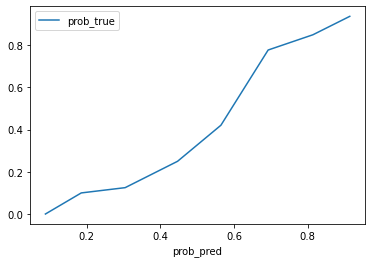

In [15]:
## Your code with comments
# YOUR CODE HERE
y_pred_proba = clf1.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=8)

result = pd.DataFrame((prob_true, prob_pred)).T
result.columns = ["prob_true", "prob_pred"]
result.plot(x="prob_pred", y="prob_true")
#raise NotImplementedError()

2.6. (4 points) Visualize distribution of predicted probabilities using a box plot or histogram

<AxesSubplot:ylabel='Frequency'>

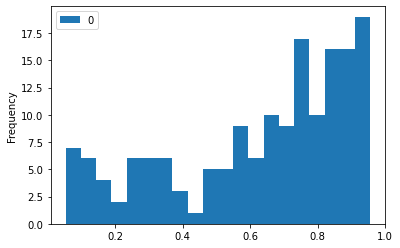

In [16]:
## Your code with comments
# YOUR CODE HERE
pd.DataFrame(y_pred_proba).plot.hist(bins=20)
#raise NotImplementedError()

2.7. (2 points) Identify predicted probability threshold to identify the top 20% highest risk students

In [21]:
## Your code with comments
# YOUR CODE HERE
twenty_percent=np.percentile(y_pred_proba, q=100-20)
#raise NotImplementedError()

# 3. Interpret (10 points)

After developing the model, moving from wrangling to analyzing the predictions generated by the model, provide your thoughts on the following questions:

3.1. What concerns do you have for deploying the model? Concerns can include model quality based on different evaluation metrics, how well the model captures what it means to be successful in the course, and potential harmful uses of the model. (5 points)

One concern I have for deploying the model is it capturing inaccurate data, which could have a negative impact on the performance of the model. Another concern is that the data could very well be overfitting or underfitting, leading to the model either being too simple or too complicated.    

3.2. Finally, how well do you think the model helps in prioritizing students to support? (5 points)

I think the model does not really help in prioritizing students to support well because even though it shows the relationship between predicted probabilities and observed failure rates, it seems more harmful than helpful, from a student's perspective. 